# [Predictive Clinical Neuroscience Toolkit](https://github.com/amarquand/PCNtoolkit) 
# Normative Modeling Tutorial Using Multi-Site Cortical Thickness Data

This notebook will prepare the data for normative modelling (assembling data matrices from different datasets, preparing the covariates etc)

### Created by [Saige Rutherford](https://twitter.com/being_saige) 

<div>
<img src="../../data/NormModelSetup.png" width="500"/>
</div>

## Step 0: Install necessary libraries & grab data files

In [ ]:
! git clone https://github.com/predictive-clinical-neuroscience/PCNtoolkit-demo.git

In [1]:
cd ../../

/Users/saigerutherford/repos/PCNtoolkit-demo


In [2]:
import os

In [ ]:
# set this path to the git cloned PCNtoolkit-demo repository --> Uncomment whichever line you need for either running on your own computer or on Google Colab.
#os.chdir('/Users/saigerutherford/repos/PCNtoolkit-demo/') # if running on your own computer, use this line (but obvi change the path)
#os.chdir('PCNtoolkit-demo/') # if running on Google Colab, use this line

In [ ]:
! pip install -r requirements.txt

## Step 1: Prepare covariate data

For this tutorial we will use data from the [Human Connectome Project Young Adult study](https://www.humanconnectome.org/study/hcp-young-adult), [CAMCAN](https://www.cam-can.org/), and [IXI](https://brain-development.org/ixi-dataset/) to create a multi-site dataset. 

Our first step is to prepare and combine the covariate (age & sex) data from each site.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joypy
from sklearn.model_selection import train_test_split
#from pcntoolkit.normative import estimate, evaluate
#from pcntoolkit.utils import create_bspline_basis, compute_MSLL

In [5]:
hcp = pd.read_csv('data/HCP1200_age_gender.csv')
cam = pd.read_csv('data/cam_age_gender.csv')
ixi = pd.read_csv('data/IXI_age_gender.csv')

In [6]:
cam_hcp = pd.merge(hcp, cam, how='outer')

In [7]:
cov = pd.merge(cam_hcp, ixi, how='outer')

/opt/anaconda3/envs/cpc_ml/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1210: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


In [8]:
sns.set(font_scale=1.5, style='darkgrid')

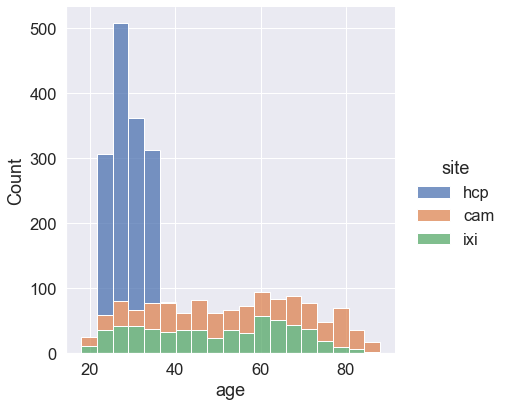

In [9]:
sns.displot(cov, x="age", hue="site", multiple="stack", height=6)

In [10]:
cov.groupby(['site']).describe()

age                                                                   \
       count       mean        std        min        25%       50%        75%   
site                                                                            
cam    656.0  54.419207  18.608285  18.000000  39.000000  55.00000  71.000000   
hcp   1206.0  28.837479   3.690534  22.000000  26.000000  29.00000  32.000000   
ixi    590.0  49.476531  16.720864  19.980835  34.027721  50.61191  63.413415   

                   sex                                               
           max   count      mean       std  min  25%  50%  75%  max  
site                                                                 
cam   88.00000   656.0  1.504573  0.500361  1.0  1.0  2.0  2.0  2.0  
hcp   37.00000  1206.0  1.543947  0.498272  1.0  1.0  2.0  2.0  2.0  
ixi   86.31896   590.0  1.555932  0.497283  1.0  1.0  2.0  2.0  2.0

# Step 2: Prepare brain data

Next we will format and combine the MRI data. We are using cortical thickness maps that are created by running recon-all from Freesurfer 6. We need to merge together the left and right hemisphere text files for each site, and then combine the different sites into a single dataframe. We reduce the dimensionality of our data by using ROIs from the Desikan-Killiany atlas. 

Here is some psuedo-code (run from a terminal in the folder that has all subject's recon-all output folders) that was used to extract these ROIs:

```export SUBJECTS_DIR=/path/to/study/freesurfer_data/```

```aparcstats2table --subject sub-* --hemi lh --meas thickness --tablefile HCP1200_aparc_lh_thickness.txt```

```aparcstats2table --subject sub-* --hemi rh --meas thickness --tablefile HCP1200_aparc_rh_thickness.txt```

In [11]:
cam = pd.read_csv('data/CAMCAN_aparc_thickness.csv')
hcpya = pd.read_csv('data/HCP1200_aparc_thickness.csv')
ixi = pd.read_csv('data/IXI_aparc_thickness.csv')

In [12]:
hcpya_cam = pd.merge(hcpya, cam, how='outer')

In [13]:
brain_all = pd.merge(ixi, hcpya_cam, how='outer')

We also want to include the [Euler number](https://mathworld.wolfram.com/EulerCharacteristic.html) as a covariate. So we extracted the euler number from each subject's recon-all output folder into a text file and we now need to format and combine these into our brain dataframe. 

Below is psuedo code for how we extracted the euler number from the recon-all.log for each subject. Run this from the terminal in the folder where your subjects recon-all output folders are located. This assumes that all of your subject IDs start with "sub-" prefix.

```for i in sub-*; do if [[ -e ${i}/scripts/recon-all.log ]]; then cat ${i}/scripts/recon-all.log | grep -A 1 "Computing euler" > temp_log; lh_en=`cat temp_log | head -2 | tail -1 | awk -F '=' '{print $2}' | awk -F ',' '{print $1}'`; rh_en=`cat temp_log | head -2 | tail -1 | awk -F '=' '{print $3}'`; echo "${i}, ${lh_en}, ${rh_en}" >> euler.csv; echo ${i}; fi; done```

In [14]:
hcp_euler = pd.read_csv('data/hcp-ya_euler.csv')
cam_euler = pd.read_csv('data/cam_euler.csv')
ixi_euler = pd.read_csv('data/ixi_euler.csv')

In [15]:
hcp_euler['site'] = 'hcp'
cam_euler['site'] = 'cam'
ixi_euler['site'] = 'ixi'

In [16]:
hcp_euler.replace(r'^\s*$', np.nan, regex=True, inplace=True)
cam_euler.replace(r'^\s*$', np.nan, regex=True, inplace=True)
ixi_euler.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [17]:
hcp_euler.dropna(inplace=True)
cam_euler.dropna(inplace=True)
ixi_euler.dropna(inplace=True)

In [18]:
hcp_euler['rh_euler'] = hcp_euler['rh_euler'].astype(int)
hcp_euler['lh_euler'] = hcp_euler['lh_euler'].astype(int)
cam_euler['rh_euler'] = cam_euler['rh_euler'].astype(int)
cam_euler['lh_euler'] = cam_euler['lh_euler'].astype(int)
ixi_euler['rh_euler'] = ixi_euler['rh_euler'].astype(int)
ixi_euler['lh_euler'] = ixi_euler['lh_euler'].astype(int)

In [19]:
hcp_cam_euler = pd.merge(hcp_euler, cam_euler, how='outer')

In [20]:
df_euler = pd.merge(ixi_euler, hcp_cam_euler, how='outer')

Finally, we need to center the euler number for each site. The euler number is very site-specific so in order to use the same exclusion threshold across sites we need to center the site by subtracting the site median from all subjects at a site. Then we will take the square root and multiply by negative one and exclude any subjects with a square root above 10. This choice of threshold is fairly random. If possible all of your data should be visually inspected to verify that the data inclusion is not too strict or too lenient. 

In [21]:
df_euler['avg_euler'] = df_euler[['lh_euler','rh_euler']].mean(axis=1)

In [22]:
df_euler.groupby(by='site').median()

,lh_euler,rh_euler,avg_euler
site,,,
cam,-62.0,-60.0,-61.0
hcp,-44.0,-44.0,-43.0
ixi,-58.0,-54.0,-56.0


In [23]:
df_euler['site_median'] = df_euler['site']

In [24]:
df_euler['site_median'] = df_euler['site_median'].replace({'hcp':-43,'cam':-61,'ixi':-56})

In [25]:
df_euler['avg_euler_centered'] = df_euler['avg_euler'] - df_euler['site_median']

In [26]:
df_euler['avg_euler_centered_neg'] = df_euler['avg_euler_centered']*-1

In [27]:
df_euler['avg_euler_centered_neg_sqrt'] = np.sqrt(np.absolute(df_euler['avg_euler_centered_neg']))

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2280x1520 with 0 Axes>

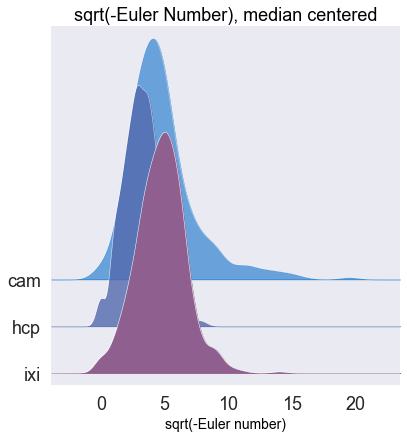

In [28]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#create a color gradent function to be used in the colormap parameter
def color_gradient(x=0.0, start=(0, 0, 0), stop=(1, 1, 1)):
    r = np.interp(x, [0, 1], [start[0], stop[0]])
    g = np.interp(x, [0, 1], [start[1], stop[1]])
    b = np.interp(x, [0, 1], [start[2], stop[2]])
    return r, g, b#show the table
#plot the figure
plt.figure(dpi=380)
fig, axes = joypy.joyplot(df_euler, column=['avg_euler_centered_neg_sqrt'], overlap=2.5, by="site", ylim='own', fill=True, figsize=(6,6)
                          , legend=False, xlabels=True, ylabels=True, colormap=lambda x: color_gradient(x, start=(.08, .45, .8),stop=(.8, .34, .44))
                          , alpha=0.6, linewidth=.5, linecolor='w', fade=True)
plt.title('sqrt(-Euler Number), median centered', fontsize=18, color='black', alpha=1)
plt.xlabel('sqrt(-Euler number)', fontsize=14, color='black', alpha=1)
plt.ylabel('Site', fontsize=14, color='black', alpha=1)
plt.show

In [29]:
brain = pd.merge(df_euler, brain_all, how='inner')

In [30]:
len(brain)

2336

In [31]:
brain_good = brain.query('avg_euler_centered_neg_sqrt < 10')

In [34]:
len(brain_good)

2299

We lose 63 subjects because they have a large euler number.

# Step 3: Combine covariate & cortical thickness dataframes

Even though the normative modeling code needs the covariate and features (cortical thickness) in separate text files, we first need to merge them together to make sure that we have the same subjects in each file and that the rows (representing subjects) align. 

In [37]:
# make sure to use how="inner" so that we only include subjects that have data in both the covariate and the cortical thickness files 
all_data = pd.merge(brain_good, cov, how='inner')

# Step 4: Format dataframes to run normative models

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
# Remove any subjects that have NaN variables in any of the columns
all_data.dropna(subset=['lh_bankssts_thickness',
       'lh_caudalanteriorcingulate_thickness',
       'lh_caudalmiddlefrontal_thickness', 'lh_cuneus_thickness',
       'lh_entorhinal_thickness', 'lh_fusiform_thickness',
       'lh_inferiorparietal_thickness', 'lh_inferiortemporal_thickness',
       'lh_isthmuscingulate_thickness', 'lh_lateraloccipital_thickness',
       'lh_lateralorbitofrontal_thickness', 'lh_lingual_thickness',
       'lh_medialorbitofrontal_thickness', 'lh_middletemporal_thickness',
       'lh_parahippocampal_thickness', 'lh_paracentral_thickness',
       'lh_parsopercularis_thickness', 'lh_parsorbitalis_thickness',
       'lh_parstriangularis_thickness', 'lh_pericalcarine_thickness',
       'lh_postcentral_thickness', 'lh_posteriorcingulate_thickness',
       'lh_precentral_thickness', 'lh_precuneus_thickness',
       'lh_rostralanteriorcingulate_thickness',
       'lh_rostralmiddlefrontal_thickness', 'lh_superiorfrontal_thickness',
       'lh_superiorparietal_thickness', 'lh_superiortemporal_thickness',
       'lh_supramarginal_thickness', 'lh_frontalpole_thickness',
       'lh_temporalpole_thickness', 'lh_transversetemporal_thickness',
       'lh_insula_thickness', 'lh_MeanThickness_thickness',
       'rh_bankssts_thickness', 'rh_caudalanteriorcingulate_thickness',
       'rh_caudalmiddlefrontal_thickness', 'rh_cuneus_thickness',
       'rh_entorhinal_thickness', 'rh_fusiform_thickness',
       'rh_inferiorparietal_thickness', 'rh_inferiortemporal_thickness',
       'rh_isthmuscingulate_thickness', 'rh_lateraloccipital_thickness',
       'rh_lateralorbitofrontal_thickness', 'rh_lingual_thickness',
       'rh_medialorbitofrontal_thickness', 'rh_middletemporal_thickness',
       'rh_parahippocampal_thickness', 'rh_paracentral_thickness',
       'rh_parsopercularis_thickness', 'rh_parsorbitalis_thickness',
       'rh_parstriangularis_thickness', 'rh_pericalcarine_thickness',
       'rh_postcentral_thickness', 'rh_posteriorcingulate_thickness',
       'rh_precentral_thickness', 'rh_precuneus_thickness',
       'rh_rostralanteriorcingulate_thickness',
       'rh_rostralmiddlefrontal_thickness', 'rh_superiorfrontal_thickness',
       'rh_superiorparietal_thickness', 'rh_superiortemporal_thickness',
       'rh_supramarginal_thickness', 'rh_frontalpole_thickness',
       'rh_temporalpole_thickness', 'rh_transversetemporal_thickness',
       'rh_insula_thickness', 'rh_MeanThickness_thickness','age','sex'], inplace=True)

Separate the covariate & features into their own dataframes

In [42]:
all_data_features = all_data[['participant_id', 'lh_bankssts_thickness',
       'lh_caudalanteriorcingulate_thickness',
       'lh_caudalmiddlefrontal_thickness', 'lh_cuneus_thickness',
       'lh_entorhinal_thickness', 'lh_fusiform_thickness',
       'lh_inferiorparietal_thickness', 'lh_inferiortemporal_thickness',
       'lh_isthmuscingulate_thickness', 'lh_lateraloccipital_thickness',
       'lh_lateralorbitofrontal_thickness', 'lh_lingual_thickness',
       'lh_medialorbitofrontal_thickness', 'lh_middletemporal_thickness',
       'lh_parahippocampal_thickness', 'lh_paracentral_thickness',
       'lh_parsopercularis_thickness', 'lh_parsorbitalis_thickness',
       'lh_parstriangularis_thickness', 'lh_pericalcarine_thickness',
       'lh_postcentral_thickness', 'lh_posteriorcingulate_thickness',
       'lh_precentral_thickness', 'lh_precuneus_thickness',
       'lh_rostralanteriorcingulate_thickness',
       'lh_rostralmiddlefrontal_thickness', 'lh_superiorfrontal_thickness',
       'lh_superiorparietal_thickness', 'lh_superiortemporal_thickness',
       'lh_supramarginal_thickness', 'lh_frontalpole_thickness',
       'lh_temporalpole_thickness', 'lh_transversetemporal_thickness',
       'lh_insula_thickness', 'lh_MeanThickness_thickness',
       'rh_bankssts_thickness', 'rh_caudalanteriorcingulate_thickness',
       'rh_caudalmiddlefrontal_thickness', 'rh_cuneus_thickness',
       'rh_entorhinal_thickness', 'rh_fusiform_thickness',
       'rh_inferiorparietal_thickness', 'rh_inferiortemporal_thickness',
       'rh_isthmuscingulate_thickness', 'rh_lateraloccipital_thickness',
       'rh_lateralorbitofrontal_thickness', 'rh_lingual_thickness',
       'rh_medialorbitofrontal_thickness', 'rh_middletemporal_thickness',
       'rh_parahippocampal_thickness', 'rh_paracentral_thickness',
       'rh_parsopercularis_thickness', 'rh_parsorbitalis_thickness',
       'rh_parstriangularis_thickness', 'rh_pericalcarine_thickness',
       'rh_postcentral_thickness', 'rh_posteriorcingulate_thickness',
       'rh_precentral_thickness', 'rh_precuneus_thickness',
       'rh_rostralanteriorcingulate_thickness',
       'rh_rostralmiddlefrontal_thickness', 'rh_superiorfrontal_thickness',
       'rh_superiorparietal_thickness', 'rh_superiortemporal_thickness',
       'rh_supramarginal_thickness', 'rh_frontalpole_thickness',
       'rh_temporalpole_thickness', 'rh_transversetemporal_thickness',
       'rh_insula_thickness', 'rh_MeanThickness_thickness']]

In [43]:
all_data_covariates = all_data[['participant_id', 'age','sex','site']]

Right now, the sites are coded in a single column using a string. We need to instead dummy encode the site variable so that there is a column for each site and the columns contain binary variables (0/1). Luckily pandas has a nice built in function, ```pd.get_dummies``` to help us format the site column this way!

In [ ]:
all_data_covariates = pd.get_dummies(all_data_covariates, columns=['site'])

In [ ]:
all_data['Average_Thickness'] = all_data[['lh_MeanThickness_thickness','rh_MeanThickness_thickness']].mean(axis=1)

Take a sneak peak to see if there are any super obvious site effects. If there were, we would see a large separation in the fitted regression line for each site.

In [ ]:
sns.set_theme(style="darkgrid",font_scale=1.5)
c = sns.lmplot(data=all_data, x="age", y="Average_Thickness", hue="site", height=6)
plt.ylim(1.5, 3.25)
plt.xlim(15, 95)
plt.show()

## Create train/test split

We will use 80% of the data for training and 20% for testing. We stratify our train/test split using the site variable to make sure that the train/test sets both contain data from all sites. The model wouldn't learn the site effects if all of the data from one site was only in the test set.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(all_data_covariates, all_data_features, stratify=all_data['site'], test_size=0.5, random_state=42)

In [45]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_test, y_test, stratify=X_test['site'], test_size=0.5, random_state=37)

In [46]:
X_train.to_csv('../CPC_ML_tutorial/data/train_covariates.csv', index=False)
y_train.to_csv('../CPC_ML_tutorial/data/train_features.csv', index=False)
X_train2.to_csv('../CPC_ML_tutorial/data/test_covariates.csv', index=False)
y_train2.to_csv('../CPC_ML_tutorial/data/test_features.csv', index=False)
X_test2.to_csv('../CPC_ML_tutorial/data/transfer_covariates.csv', index=False)
y_test2.to_csv('../CPC_ML_tutorial/data/transfer_features.csv', index=False)

Verify that your train & test arrays are the same size

In [ ]:
tr_cov_size = X_train.shape
tr_resp_size = y_train.shape
te_cov_size = X_test.shape
te_resp_size = y_test.shape
print("Train covariate size is: ", tr_cov_size)
print("Test covariate size is: ", te_cov_size)
print("Train response size is: ", tr_resp_size)
print("Test response size is: ", te_resp_size)

### Save out each ROI to its own file

We setup the normative model so that for each Y (brain region) we fit a separate model. While the estimate function in the pcntoolkit can handle having all of the Y's in a single text file, for this tutorial we are going to organize our Y's so that they are each in their own text file and directory. 

In [ ]:
os.chdir('/Users/saigerutherford/repos/PCNToolkit-demo/')

In [ ]:
cd data/

In [ ]:
for c in y_train.columns:
    y_train[c].to_csv('resp_tr_' + c + '.txt', header=False, index=False)

In [ ]:
X_train.to_csv('cov_tr.txt', sep = '\t', header=False, index = False)

In [ ]:
y_train.to_csv('resp_tr.txt', sep = '\t', header=False, index = False)

In [ ]:
for c in y_test.columns:
    y_test[c].to_csv('resp_te_' + c + '.txt', header=False, index=False)

In [ ]:
X_test.to_csv('cov_te.txt', sep = '\t', header=False, index = False)

In [ ]:
y_test.to_csv('resp_te.txt', sep = '\t', header=False, index = False)

In [ ]:
! if [[ ! -e data/ROI_models/ ]]; then mkdir data/ROI_models; fi
! if [[ ! -e data/covariate_files/ ]]; then mkdir data/covariate_files; fi
! if [[ ! -e data/response_files/ ]]; then mkdir data/response_files; fi

In [ ]:
! for i in `cat data/roi_dir_names`; do cd data/ROI_models; mkdir ${i}; cd ../../; cp resp_tr_${i}.txt data/ROI_models/${i}/resp_tr.txt; cp resp_te_${i}.txt data/ROI_models/${i}/resp_te.txt; cp cov_tr.txt data/ROI_models/${i}/cov_tr.txt; cp cov_te.txt data/ROI_models/${i}/cov_te.txt; done

In [ ]:
! mv resp_*.txt data/response_files/

In [ ]:
! mv cov_t*.txt data/covariate_files/

# Step 5: Run normative model

In [ ]:
# set this path to wherever your ROI_models folder is located (where you copied all of the covariate & response text files to in Step 4)
data_dir = '/Users/saigerutherford/repos/PCNToolkit-demo/data/ROI_models/'

In [ ]:
# Create a list of all the ROIs you want to run a normative model for
roi_ids = ['lh_MeanThickness_thickness',
           'rh_MeanThickness_thickness',
           'lh_bankssts_thickness',
           'lh_caudalanteriorcingulate_thickness',
           'lh_superiorfrontal_thickness',
           'rh_superiorfrontal_thickness']

When we split the data into train and test sets, we did not reset the index. This means that the row numbers in the train/test matrices are still the same as before splitting the data. We will need the test set row numbers of which subjects belong to which site in order to evaluate per site performance metrics, so we need to reset the row numbers in the train/test split matrices.

In [ ]:
x_col_names = ['age', 'sex', 'site_cam', 'site_hcp', 'site_ixi']
X_train = pd.read_csv('data/covariate_files/cov_tr.txt', sep='\t', header=None, names=x_col_names)
X_test = pd.read_csv('data/covariate_files/cov_te.txt', sep='\t', header=None, names=x_col_names)
y_train = pd.read_csv('data/response_files/resp_tr.txt', sep='\t', header=None)
y_test = pd.read_csv('data/response_files/resp_te.txt', sep='\t', header=None)

In [ ]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

### Extract site indices

Get site ids so that we can evaluate the test metrics independently for each site

In [ ]:
cam_idx = X_test.index[X_test['site_cam' ]== 1].to_list()
hcp_idx = X_test.index[X_test['site_hcp'] == 1].to_list()
ixi_idx = X_test.index[X_test['site_ixi'] == 1].to_list()

# Save the site indices into a single list
sites = [cam_idx, hcp_idx, ixi_idx]

# Create a list with sites names to use in evaluating per-site metrics
site_names = ['cam', 'hcp', 'ixi']

### Basis expansion

Now, we set up a B-spline basis set that allows us to perform nonlinear regression using a linear model. This basis is deliberately chosen to not to be too flexible so that in can only model relatively slowly varying trends. To increase the flexibility of the model you can change the parameterisation (e.g. by adding knot points to the Bspline basis or increasing the order of the interpolating polynomial). 

Note that in the neuroimaging literature, it is more common to use a polynomial basis expansion for this. Piecewise polynomials like B-splines are superior because they do not introduce a global curvature. See the reference below for further information.

[Primer on regression splines](https://cran.r-project.org/web/packages/crs/vignettes/spline_primer.pdf)

[Reference for why polynomials are a bad idea](https://www.sciencedirect.com/science/article/abs/pii/S1053811910000832?via%3Dihub)


In [ ]:
# Create a cubic B-spline basis (used for regression)
xmin = 10#16 # xmin & xmax are the boundaries for ages of participants in the dataset
xmax = 95#90
B = create_bspline_basis(xmin, xmax)

# create the basis expansion for the covariates for each of the 
for roi in roi_ids: 
    print('Creating basis expansion for ROI:', roi)
    roi_dir = os.path.join(data_dir, roi)
    os.chdir(roi_dir)
    
    # create output dir 
    os.makedirs(os.path.join(roi_dir,'blr'), exist_ok=True)
    
    # load train & test covariate data matrices
    X_tr = np.loadtxt(os.path.join(roi_dir, 'cov_tr.txt'))
    X_te = np.loadtxt(os.path.join(roi_dir, 'cov_te.txt'))

    # add intercept column 
    X_tr = np.concatenate((X_tr, np.ones((X_tr.shape[0],1))), axis=1)
    X_te = np.concatenate((X_te, np.ones((X_te.shape[0],1))), axis=1)
    np.savetxt(os.path.join(roi_dir, 'cov_int_tr.txt'), X_tr)
    np.savetxt(os.path.join(roi_dir, 'cov_int_te.txt'), X_te)
    
    # create Bspline basis set 
    Phi = np.array([B(i) for i in X_tr[:,0]])
    Phis = np.array([B(i) for i in X_te[:,0]])
    X_tr = np.concatenate((X_tr, Phi), axis=1)
    X_te = np.concatenate((X_te, Phis), axis=1)
    np.savetxt(os.path.join(roi_dir, 'cov_bspline_tr.txt'), X_tr)
    np.savetxt(os.path.join(roi_dir, 'cov_bspline_te.txt'), X_te)

### Prepare output structures

In [ ]:
# Create pandas dataframes with header names to save out the overall and per-site model evaluation metrics
blr_metrics = pd.DataFrame(columns = ['ROI', 'MSLL', 'EV', 'SMSE', 'RMSE', 'Rho'])
blr_site_metrics = pd.DataFrame(columns = ['ROI', 'site', 'y_mean', 'y_var', 'yhat_mean', 'yhat_var', 'MSLL', 'EV', 'SMSE', 'RMSE', 'Rho'])

### Estimate the normative models

In this step, we estimate the normative models one at a time. In principle we could also do this on the whole data matrix at once (e.g. with the response variables stored in a n_subjects x n_brain_measures numpy array). However, doing it this way gives us some extra flexibility in that it does not require that the subjects are exactly the same for each of the brain measures. 

This code fragment will loop through each region of interest in the roi_ids list (set a few code blocks above) using Bayesian linear regression and evaluate the model on the independent test set. It will then compute error metrics such as the explained variance, mean standardized log loss and Pearson correlation between true and predicted test responses separately for each scanning site. 

We supply the estimate function with a few specific arguments that are worthy of commenting on: 
* alg = 'blr' : specifies we should use Bayesian linear regression
* optimizer = 'powell' : use Powell's derivative-free optimization method (faster in this case than L-BFGS)
* savemodel = False : do not write out the final estimated model to disk
* saveoutput = False : return the outputs directly rather than writing them to disk
* standardize = False : Do not standardize the covariates or response variables

One important consideration is whether or not to standardize. Whilst this generally only has a minor effect on the final model accuracy, it has implications for the interpretation of models and how they are configured. If the covariates and responses are both standardized, the model will return standardized coefficients. If (as in this case) the response variables are not standardized, then the scaling both covariates and responses will be reflected in the estimated coefficients. Also, under the linear modelling approach employed here, if the coefficients are unstandardized and do not have a zero mean, it is necessary to add an intercept column to the design matrix. This is done in the code block above. 

In [ ]:
# Loop through ROIs
for roi in roi_ids: 
    print('Running ROI:', roi)
    roi_dir = os.path.join(data_dir, roi)
    os.chdir(roi_dir)
     
    # configure the covariates to use. Change *_bspline_* to *_int_* to 
    cov_file_tr = os.path.join(roi_dir, 'cov_bspline_tr.txt')
    cov_file_te = os.path.join(roi_dir, 'cov_bspline_te.txt')
    
    # load train & test response files
    resp_file_tr = os.path.join(roi_dir, 'resp_tr.txt')
    resp_file_te = os.path.join(roi_dir, 'resp_te.txt') 
    
    # run a basic model
    yhat_te, s2_te, nm, Z, metrics_te = estimate(cov_file_tr, 
                                                 resp_file_tr, 
                                                 testresp=resp_file_te, 
                                                 testcov=cov_file_te, 
                                                 alg = 'blr', 
                                                 optimizer = 'powell', 
                                                 savemodel = False, 
                                                 saveoutput = False,
                                                 standardize = False)
    # display and save metrics
    print('EV=', metrics_te['EXPV'][0])
    print('RHO=', metrics_te['Rho'][0])
    print('MSLL=', metrics_te['MSLL'][0])
    blr_metrics.loc[len(blr_metrics)] = [roi, metrics_te['MSLL'][0], metrics_te['EXPV'][0], metrics_te['SMSE'][0], 
                                         metrics_te['RMSE'][0], metrics_te['Rho'][0]]
    
    # Compute metrics per site in test set, save to pandas df
    # load true test data
    X_te = np.loadtxt(cov_file_te)
    y_te = np.loadtxt(resp_file_te)
    y_te = y_te[:, np.newaxis] # make sure it is a 2-d array
    
    # load training data (required to compute the MSLL)
    y_tr = np.loadtxt(resp_file_tr)
    y_tr = y_tr[:, np.newaxis]
    
    for num, site in enumerate(sites):     
        y_mean_te_site = np.array([[np.mean(y_te[site])]])
        y_var_te_site = np.array([[np.var(y_te[site])]])
        yhat_mean_te_site = np.array([[np.mean(yhat_te[site])]])
        yhat_var_te_site = np.array([[np.var(yhat_te[site])]])
        
        metrics_te_site = evaluate(y_te[site], yhat_te[site], s2_te[site], y_mean_te_site, y_var_te_site)
        
        site_name = site_names[num]
        blr_site_metrics.loc[len(blr_site_metrics)] = [roi, site_names[num],
                                                       y_mean_te_site[0],
                                                       y_var_te_site[0],
                                                       yhat_mean_te_site[0],
                                                       yhat_var_te_site[0],
                                                       metrics_te_site['MSLL'][0],
                                                       metrics_te_site['EXPV'][0],
                                                       metrics_te_site['SMSE'][0],
                                                       metrics_te_site['RMSE'][0],
                                                       metrics_te_site['Rho'][0]]

In [ ]:
os.chdir(data_dir)

In [ ]:
# Save per site test set metrics variable to CSV file
blr_site_metrics.to_csv('blr_site_metrics.csv', index=False, index_label=None)

In [ ]:
# Save overall test set metrics to CSV file
blr_metrics.to_csv('blr_metrics.csv', index=False, index_label=None)

# Step 6: Interpreting model performance

Output evaluation metrics definitions: 
* yhat - predictive mean
* ys2 - predictive variance
* nm - normative model
* Z - deviance scores
* Rho - Pearson correlation between true and predicted responses
* pRho - parametric p-value for this correlation
* RMSE - root mean squared error between true/predicted responses
* SMSE - standardised mean squared error
* EV - explained variance
* MSLL - mean standardized log loss
    * See page 23 in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf